# I. Introduction
=================================================

**Objective :** \
Notebook ini digunakan untuk proses modelling untuk membuat aplikasi rekomendasi smart watch berbasis NLP. 
Metode pengolahan data text pre-processing dilakukan dengan menggunakan library nltk.
Selanjutnya untuk menentukan kesesuaian teks menggunakan library word2vec dan algoritma cosine similaity


=================================================

# II. Import Library


Bagian ini digunakan untuk memuat library yang diperlukan

In [38]:
# Import Libraries

import re
import nltk
import string
import random
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from wordcloud import WordCloud
from gensim.models import Word2Vec
from nltk.util import ngrams

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KAISAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\KAISAR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KAISAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\KAISAR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# III. Load Data

Pada bagian ini dataset dimuat dan dilakukan pengecekan data

In [39]:
# Memuat dataset
df_review = pd.read_csv("data_review.csv")
df_product = pd.read_csv("data_product.csv")

In [40]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   products           1103 non-null   object 
 1   individual_review  1103 non-null   object 
 2   individual_rating  1103 non-null   float64
dtypes: float64(1), object(2)
memory usage: 26.0+ KB


In [41]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   products      280 non-null    object 
 1   rating        280 non-null    float64
 2   price         280 non-null    float64
 3   features      280 non-null    object 
 4   battery       280 non-null    float64
 5   connectivity  280 non-null    object 
 6   gps           280 non-null    float64
 7   screen_size   280 non-null    float64
 8   img_url       280 non-null    object 
 9   brand         280 non-null    object 
dtypes: float64(5), object(5)
memory usage: 22.0+ KB


In [42]:
# Cek duplicate data review
df_review.duplicated().sum()

0

In [43]:
# Cek duplicate data product
df_product.duplicated().sum()

0

Setelah data dipastikan bebas dari null value dan duplicate data, dilakukan proses labelling berdasarkan rating reviews untuk menentukan apakah reviews tersebut bersentimen positif, netral, atau negatif.

In [44]:
# proses labelling
label=[]

for i in df_review['individual_rating']:
    if i < 3 :
        label.append('Negative')
    elif i >3 :
        label.append('Positive')
    else: label.append('Neutral')

df_review['label']=label

# IV. Exploratory Data Analysis (EDA)

Pada bagian ini dilakukan analisis sederhana pada dataset untuk mengentahui karakteristik data terutama dataset review yang akan menjadi fokus model

## Perbandingan Data Sentiment

In [45]:
# Menghitung jumlah data
df_review['label'].value_counts()

label
Positive    955
Negative    109
Neutral      39
Name: count, dtype: int64

C:\Users\KAISAR\AppData\Local\Temp\ipykernel_7484\1187149909.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_review, x='label', palette='bright')


<Axes: xlabel='label', ylabel='count'>

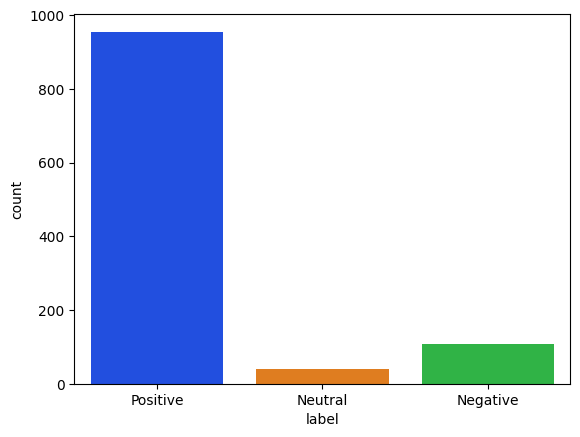

In [46]:
# Menampilkan data
sns.countplot(data=df_review, x='label', palette='bright')

Dari seluruh data reviews sebagian besar dat mengandung sentimen psotif, hanya terdapat beberapa reviews dengan sentiment negatif atau netral

## Wordcloud

Wordcloud digunakan untuk melihat kata-kata apa yang sering muncul dari dataset reviews

In [47]:
# Tokenization
def tokenizingText(text):
    """
    Fungsi untuk memecah teks menjadi daftar kata atau token.

    Params:
    Text(string) : Text yang ingin dirubah menjadi token
    """
    text = word_tokenize(text)
    return text

df_review['token'] = df_review['individual_review'].apply(tokenizingText)

In [48]:
# Fungsi untuk membuat word cloud
def generate_wordcloud(data, column_name, title):
    """
    Fungsi untuk membuat Word Cloud dari teks di kolom yang ditentukan.

    Params:
    - data (pd.DataFrame): DataFrame berisi teks yang ingin ditampilkan.
    - column_name (str): Nama kolom dalam DataFrame yang berisi teks yang akan digunakan untuk Word Cloud.
    - title (str): Judul Word Cloud yang ingin ditampilkan.
    """
    # Menggabungkan semua kata dalam kolom yang diberikan menjadi satu string
    list_words = ' '.join([' '.join(tweet) for tweet in data[column_name]])

    # Membuat Word Cloud
    wordcloud = WordCloud(width=800, height=600, background_color='white', random_state=32, min_font_size=10).generate(list_words)

    # Menampilkan Plot Word Cloud
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title, fontsize=18)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.show()

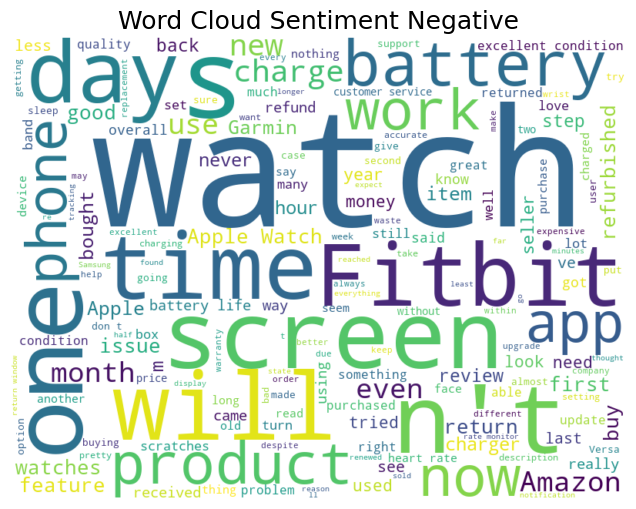

In [49]:
#Menampilkan wordcloud sentiment negative
generate_wordcloud(df_review[df_review['label']=='Negative'], 'token', 'Word Cloud Sentiment Negative')

Pada sentiment negatif kata yang sering keluar adalah jam, layar, fitbit, dll.

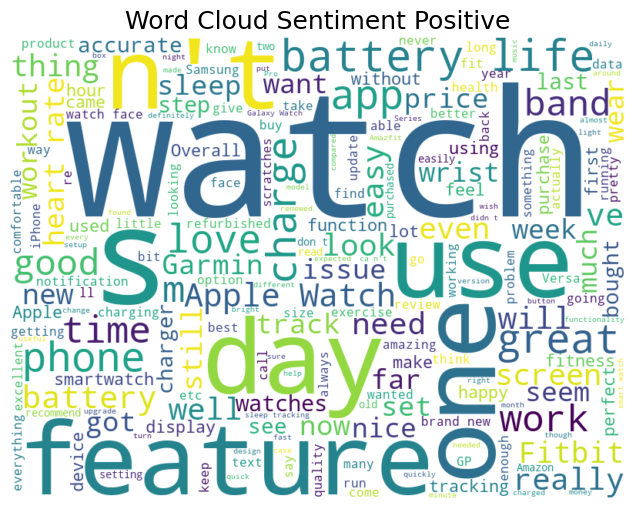

In [50]:
#Menampilkan wordcloud sentiment negative
generate_wordcloud(df_review[df_review['label']=='Positive'], 'token', 'Word Cloud Sentiment Positive')

Pada sentiment positif kata-kata yang sering keluar adalah jam, feature, battery, dll.

# V. Text Pre-processing

Text pre-processing dilakukan untuk membersihkan kata-kata dari karakter yang tidak diperlukan dan menjadikan kata menjadi kata baku

In [51]:
# Cleaning Text
def cleaningText(text):
    """
    Fungsi untuk membersihkan teks dari elemen yang tidak diinginkan

    Params:
    Text(String): Teks yang ingin dibersihkan
    """
    text = re.sub(r'\d+', '', text) # menghapus angka
    text = re.sub(r'\b(\w+)-\1\b', r'\1', text) # menhapus kata ulang
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus spasi / whitespaces
    return text

df_review['clean_text']= df_review['individual_review'].apply(lambda x: cleaningText(x))

In [52]:
# Casefolding
def casefolding(text):
    """
    Fungsi untuk mengubah semua karakter dalam teks menjadi huruf kecil

    Params:
    Text(String): Teks yang ingin dirubah
    """
    text = text.lower()
    return text

df_review['clean_text']= df_review['clean_text'].apply(casefolding)

In [53]:
 # Tokenization
df_review['token'] = df_review['clean_text'].apply(tokenizingText)

In [54]:
# Memuat file slangwords
with open('slangwords.txt', 'r', encoding='utf-8') as f:
    slangwords = json.load(f)

In [55]:
# Slangwords
def normalisasi(text):
    """
    Fungsi untuk melakukan normalisasi teks
    Jika kata termasuk dalam slangwords ganti menjadi kata baku

    Params:
    Text(String): Teks yang ingin dibersihkan
    """
    formal = []
    for word in text:
        if word in slangwords:
            formal.append(slangwords[word])
        else:
            formal.append(word)
    text = formal
    return text

df_review['token']= df_review['token'].apply(normalisasi)

In [56]:
# Stopwords
def filteringText(text):
    """
    Fungsi untuk menghilangkan stopwords yang ada dalam teks
    Jika teks terdapat dalam stopwords maka akan dihilangkan

    Params:
    Text(String): Teks yang ingin dibersihkan
    """
    stop_words = stopwords.words("english") 
    stop_words = list(set(stop_words))

    filtered = []
    for word in text:
        if word not in stop_words:
            filtered.append(word)
    text = filtered
    return text

df_review['token']= df_review['token'].apply(filteringText)

In [57]:
# POS Detection
def get_wordnet_pos(tag):
    """
    Fungsi untuk menentukan jenis kata dalam suatu kalimat (POS)
    Param:
        text (List[str]): token-token dari kalimat
    Return:
        text type (POS)
    """
    if tag.startswith('J'):
        return wordnet.ADJ  # adjective
    elif tag.startswith('V'):
        return wordnet.VERB  # verb
    elif tag.startswith('N'):
        return wordnet.NOUN  # noun
    elif tag.startswith('R'):
        return wordnet.ADV  # adverb
    else:
        return wordnet.NOUN  # default ke noun
    
# Lemmatization
def lemmatizeText(text):
    """
    Fungsi untuk melakukan lemmatization dengan POS otomatis.
    Param:
        text (List[str]): token-token dari kalimat
    Return:
        List[str]: hasil lemmatization
    """
    lemmatizer = WordNetLemmatizer()

    # Deteksi POS
    pos_tags = pos_tag(text)

    # Lemmatization berdasarkan token
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return tokens


df_review['token']= df_review['token'].apply(lemmatizeText)

In [58]:
# Menggabungkan token menjadi clean_text
def fullText(tokens):
  sentence = text = ' '.join(tokens)
  return sentence

df_review['clean_text'] = df_review['token'].apply(fullText)

In [59]:
def preprocessing(teks):
    """
    Fungsi untuk memanggil seluruh method pre-processing sebelumnya
    Param:
        text (List[str]): token-token dari kalimat
    Return:
        text (List[str]): token-token dari kalimat
    """
    teks = teks.apply(casefolding)
    teks = teks.apply(tokenizingText)
    teks = teks.apply(normalisasi)
    teks = teks.apply(filteringText)
    teks = teks.apply(lemmatizeText)

    return teks

## Combine Dataset

Setelah dataset reviews dibersihkan selanjutnya disatukan dengan dataset product untuk mendapatkan seluruh informasi dari sebuah produk

In [60]:
# Gabungkan berdasarkan nama produk
df = df_review.merge(df_product, on="products", how="left")
df

,products,individual_review,individual_rating,label,token,clean_text,rating,price,features,battery,connectivity,gps,screen_size,img_url,brand
0,Amazfit Bip 6,I purchased this watch to replace a dead Samsu...,5.0,Positive,"[purchase, watch, replace, dead, samsung, gala...",purchase watch replace dead samsung galaxy wat...,4.5,74.99,"Multisport Tracker, Text Messaging, AI Assista...",340.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/61UvVTN0IE...,Amazfit
1,Amazfit Bip 6,"Pleasantly surprised. Finally, a less expensiv...",5.0,Positive,"[pleasantly, surprise, finally, less, expensiv...",pleasantly surprise finally less expensive wat...,4.5,74.99,"Multisport Tracker, Text Messaging, AI Assista...",340.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/61UvVTN0IE...,Amazfit
2,Amazfit Bip 6,If you’re looking to purchase a smart watch th...,5.0,Positive,"[youre, look, purchase, smart, watch, affordab...",youre look purchase smart watch affordable bil...,4.5,74.99,"Multisport Tracker, Text Messaging, AI Assista...",340.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/61UvVTN0IE...,Amazfit
3,Amazfit Bip 6,"This watch does well, considered the price. Th...",4.0,Positive,"[watch, well, consider, price, function, capab...",watch well consider price function capability ...,4.5,74.99,"Multisport Tracker, Text Messaging, AI Assista...",340.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/61UvVTN0IE...,Amazfit
4,Amazfit Bip 6,This watch is amazing quality for the price! I...,5.0,Positive,"[watch, amaze, quality, price, smart, watch, m...",watch amaze quality price smart watch major co...,4.5,74.99,"Multisport Tracker, Text Messaging, AI Assista...",340.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/61UvVTN0IE...,Amazfit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8726,Xiaomi Redmi Watch 4,Great watch for working out and keeping track ...,5.0,Positive,"[great, watch, work, keep, track, fitness, als...",great watch work keep track fitness also monto...,4.4,74.99,Heart Rate Monitor,12000.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/71tozl-916...,Xiaomi
8727,Xiaomi Redmi Watch 4,I have had a number of smartwatches including ...,4.0,Positive,"[number, smartwatches, include, several, diffe...",number smartwatches include several different ...,4.4,74.99,Heart Rate Monitor,12000.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/71tozl-916...,Xiaomi
8728,Xiaomi Redmi Watch 4,Awsome product... Good price and reabilty,5.0,Positive,"[awsome, product, good, price, reabilty]",awsome product good price reabilty,4.4,74.99,Heart Rate Monitor,12000.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/71tozl-916...,Xiaomi
8729,Xiaomi Redmi Watch 4,"My husband used it after he got it, very relia...",5.0,Positive,"[husband, use, get, reliable, battery, life, c...",husband use get reliable battery life charge w...,4.4,74.99,Heart Rate Monitor,12000.0,Bluetooth,1.0,1.97,https://m.media-amazon.com/images/I/71tozl-916...,Xiaomi


In [61]:
# # Membuat kolom baru untuk data target
# df['combined_text'] = (
#     df['products'].fillna('') + ' ' +
#     df['features'].fillna('') + ' ' +
#     df['individual_review'].fillna('')
# )

# V.I Modelling

Pada project ini proses word embedding atau pembobotan token dilakukan menggunakan library word2vec yang dilatih menggunakan dataset yang sudah dibersihkan.

In [62]:
# Membuat model word2vec
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

w2v_model = Word2Vec(sentences=df.token,seed=SEED, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [63]:
# Fungsi untuk dapatkan average vector dari satu kalimat
def get_sentence_vector(sentence_tokens, model):
    """
    Fungsi untuk men-transormasi teks menjadi vector
    Param:
        List(str) : token kata
        model : model word2vec
    Return:
        List(float) : list vector
    """
    vectors = []
    for token in sentence_tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [64]:
# Trigram

def to_trigrams(tokens):
    """
    Fungsi untuk mengubah list token menjadi trigram ['kata1','kata2','kata3']
    Param:
        Teks(str) : list token
    Return:
        teks(str) : list trigram
    """
    return ['_'.join(gram) for gram in ngrams(tokens, 3)]

def preprocessing_with_trigram(text_series):
    """
    Fungsi untuk memanggil proses text pre-processing dan trigram
    Params:
        teks : list teks
    Return:
        teks : list token + trigram
    """
    result = []
    for text in text_series:
        # Melakukan pre-processing data
        tokens = preprocessing(pd.Series([text])).iloc[0]
        
        # Menggabungkan tokens dan trigrams
        trigram_tokens = to_trigrams(tokens)
        combined = tokens + trigram_tokens
        result.append(combined)
    return result

## Model Training


In [72]:
# Menggabungkan seluruh data kolom menjadi data target
df['spect'] = (
    df['products']+ ' ' +
    df['features'] + ' ' +
    df['clean_text'] + ' ' +
    df['brand']+ ' ' +
    df['connectivity'] + ' ' +
    df['gps'].astype(str)
)


In [73]:
# Data inference
input = {
    "brand" : "Samsung",
    "harga" : 200,
    "keyword": "great battery capacity for outdoor"
}

In [74]:
# Menggabungkan data inference menjadi sebuah string
user_input=""

for value in input.values():
    user_input += str(value) + " "

# Membuat list token + trigram
user_input_tokens = preprocessing_with_trigram(pd.Series([user_input]))[0]
df['spect'] = preprocessing_with_trigram(df['spect'])

In [75]:
# Vektor dari input user
input_vector = get_sentence_vector(user_input, w2v_model)

similarities = []

# Menghitung similarity untuk setiap kalimat
for sentence_tokens in df['spect']:
    sentence_vector = get_sentence_vector(sentence_tokens, w2v_model)
    similarity = cosine_similarity([input_vector], [sentence_vector])[0][0]
    similarities.append(similarity)

# Menambahkan similarity ke DataFrame
df['similarity'] = similarities

# Mengurutkan berdasarkan similarity
df_sorted = df.sort_values(by='similarity', ascending=False)

# Mengambil 3 produk dengan similarity tertinggi
top3 = df_sorted.drop_duplicates(subset='products', keep='first').head(3)

# Cetak hasil
print("Top 3 product berdasarkan reviews:")
for i, row in top3.iterrows():
    original_text = ' '.join(row['spect'])  
    print(f"{i+1}. Product: {row['products']} | Kalimat: '{original_text}' --> Similarity: {row['similarity']:.4f}")


Top 3 product berdasarkan reviews:
5490. Product: Fitbit Google Ace Lte | Kalimat: 'fitbit google ace lte messaging , call , location , activity base game prepare child send boat load poop emojis hahapros fun fast ui lot explore encourage kid move fun way bright clear screen game require child first move active playing game active global positioning system location work fast somehow even faster find iphones work wifi text message call voice message quick responsive work wifi dedicate ace parental application work well iphone good parental control peace mind close ecosystem kid cant message anyoneneutral data plan independent carrier battery life meh charge fast itll get though day depend screen brightness usecons fitbits historical reputation reliability support subpar device time tell device well make operate smoothly fargames fitness challenge scout fitness coach decorate house item purchase movementactivity golf mini gamesas parent want able keep touch kid go friend house field trip

In [76]:
top3

,products,individual_review,individual_rating,label,token,clean_text,rating,price,features,battery,connectivity,gps,screen_size,img_url,brand,spect,similarity
5489,Fitbit Google Ace Lte,Prepare for your child to send you a boat load...,5.0,Positive,"[prepare, child, send, boat, load, poop, emoji...",prepare child send boat load poop emojis hahap...,3.9,123.45,"Messaging, Calling, Location, Activity Based G...",3600.0,Cellular (4G LTE),1.0,1.60,https://m.media-amazon.com/images/I/71hyEmvSTo...,Fitbit,"[fitbit, google, ace, lte, messaging, ,, call,...",0.861717
6493,Huawei Watch Gt 4,There is NOTHING on the market that compares t...,5.0,Positive,"[nothing, market, compare, watch, style, funct...",nothing market compare watch style functionali...,4.7,224.19,"Long battery life, health sensors, sports trac...",530.0,Bluetooth,1.0,1.43,https://m.media-amazon.com/images/I/71u9PXWPzF...,Huawei,"[huawei, watch, gt, 4, long, battery, life, ,,...",0.855653
7612,Samsung Galaxy Watch5,I was looking into a fitness tracker when I st...,5.0,Positive,"[look, fitness, tracker, stumble, across, amaz...",look fitness tracker stumble across amazon ref...,4.3,84.00,"ECG, GPS",1250.0,Bluetooth,1.0,1.40,https://m.media-amazon.com/images/I/51p8TZs04d...,Samsung,"[samsung, galaxy, watch5, ecg, ,, global posit...",0.853153


Hasil output model menampilkan 3 produk yang sesuai dengan keyword yang dimasukkan pelanggan berdasarkan nilai similarity dengan reviews yang diberikan oleh pembeli sebelumnya.
Pada hasil rekomendasi diatas terdapat 2 produk selain kategori samsung, hal ini karena model difokuskan pada data teks / keyword yang dimasukkan oleh pengguna. Sehingga nilai produk dengan similarity tertinggi akan menhasilkan rekomendasi dengan reviews terhadap batery dan outdoor activity yang bagus.